<a href="https://colab.research.google.com/github/jgjoao5/DeepLearningv2/blob/master/Hotel_Description_Vf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential

import keras.utils as ku 
import pandas as pd
import numpy as np
import string, os 
import warnings
!pip install langdetect
import langdetect
#!pip install transformers
#!pip install pytorch
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
#import tensorflow as tf
#from transformers import TFGPT2LMHeadModel, GPT2Tokenizer
!pip install tabulate
from tabulate import tabulate
!pip install wordcloud
from google.colab import drive
drive.mount('/content/gdrive')

# Aplicando o modelo proposto no Artigo

Artigo de Referência:

https://towardsdatascience.com/automatically-generate-hotel-descriptions-with-lstm-afa37002d4fc

https://github.com/susanli2016/NLP-with-Python/blob/master/Hotel%20Description%20Generation%20LSTM.ipynb


In [6]:
#Carreando a base
hotel_df= pd.read_json('/content/gdrive/My Drive/Colab Notebooks/inventory_hotel_BR_pt.json')


In [7]:
#Manipulando a base para diminuir o numero de linhas e trabalhar apenas com as colunas necessárias 
hotel_df = hotel_df[['name','description']]
hotel_df = hotel_df[0:500]
all_descriptions = list(hotel_df['description'].values)

hotel_df

,name,description
0,Best Western Hôtel New York Nice,"Located in Nice's city center, Best Western Ho..."
1,Comfort Inn Hyde Park,"In London's Bayswater district, the Comfort In..."
2,Best Western Plus Dayton Hotel & Suites,Breakfast is offered daily and rooms feature f...
3,"The Elizabeth Hotel, Autograph Collection","The Elizabeth Hotel, Autograph Collection feat..."
4,Grand Mercure Vila Olímpia,"Localizado no coração de São Paulo, o Grand Me..."
...,...,...
495,Kelta,"In the Hostería Kelta, located in the Province..."
496,WorldMark Running Y,"Offering an indoor swimming pool, this Klamath..."
497,Hotel Kirst,<h3>Localização Do Estabelecimento</h3>\nCom u...
498,Motel 6,A short drive from beautiful beaches and easil...


In [8]:
hotel_df.shape


(500, 2)

In [9]:
#Exemplo da descrção de um dos hoteis da base.
corpus = [x for x in all_descriptions]
corpus[:1]


["Located in Nice's city center, Best Western Hotel Lakmi Nice is located on Avenue Jean Medecin, Nice's main shopping street which leads to Place Massena. It is next to Nice Etoile Shopping Center and is just 1969 feet from Nice- Ville Train Station. Each spacious air-conditioned guest room has a flat- screen TV and a private bathroom fitted with a hairdryer. Some of the soundproofed rooms feature wrought iron furniture and some rooms offer a balcony. WiFi access is available throughout the hotel. A buffet breakfast is served every morning in the breakfast room at the Best Western Hotel Lakmi Nice. Newspapers are available for guests and there is also a bar on site. The Promenade des Anglais is a 13-minute walk from the hotel and Vieux Nice, the historic district, is a 15-minute walk away. Six private parking spaces are available on site at an additional cost, which cannot be booked in advance. ((* Sorry, this information is not available in the selected language and is shown in EN)."

In [10]:
#Padronizando os textos(aplicação de letra minuscula,retirada de caracteres especiais) 
#levantamento de contagem de palavras e recorrência 

t = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token=None, document_count=0)
t.fit_on_texts(corpus)

In [11]:
from collections import OrderedDict
# A dictionary of words and their counts.
word_counts = t.word_counts
sorted_words = OrderedDict(sorted(word_counts.items(), key=lambda x: x[1], reverse=True))
top_30_words = list(sorted_words.items())[:30]
print("top30 palavras mais recorrentes:")
for word, count in top_30_words:
    print(f"{word}: {count}")


#print(t.word_counts.sorted())

# A dictionary of words and how many documents each appeared in.
print(t.word_docs)

# An integer count of the total number of documents that were used to fit the Tokenizer (i.e. total number of documents)
print(t.document_count)

# A dictionary of words and their uniquely assigned integers.
print(t.word_index)

top30 palavras mais recorrentes:
the: 2940
and: 2931
a: 2585
is: 2203
in: 1800
de: 1308
hotel: 994
mi: 942
of: 853
km: 847
this: 771
with: 758
from: 730
available: 718
at: 638
e: 597
1: 591
br: 580
as: 544
to: 517
are: 515
rooms: 505
free: 495
2: 474
0: 444
not: 435
en: 433
information: 430
selected: 430
language: 422
defaultdict(<class 'int'>, {'cost': 7, 'some': 68, 'language': 421, 'promenade': 2, 'minute': 116, 'jean': 1, 'throughout': 36, 'information': 421, 'furniture': 12, "nice's": 1, 'room': 192, 'balcony': 37, 'an': 203, 'screen': 150, 'buffet': 80, 'avenue': 5, 'feature': 73, 'street': 25, 'flat': 147, 'iron': 6, 'hairdryer': 51, 'additional': 29, 'advance': 3, 'there': 37, 'and': 430, 'at': 313, 'shown': 421, 'morning': 39, 'city': 98, 'sorry': 421, 'feet': 55, 'not': 423, 'with': 339, '15': 81, 'conditioned': 78, 'guest': 90, 'district': 37, 'parking': 126, 'next': 10, 'to': 267, 'spaces': 3, 'on': 193, 'this': 421, 'rooms': 281, 'selected': 421, 'offer': 53, 'station': 64

In [ ]:
!pip install --upgrade pip

!pip install --upgrade Pillow

  Attempting uninstall: pip
    Found existing installation: pip 21.2.4
    Uninstalling pip-21.2.4:
      Successfully uninstalled pip-21.2.4


     ---------------------------------------- 2.5/2.5 MB 12.5 MB/s eta 0:00:00
  Attempting uninstall: Pillow


    Found existing installation: Pillow 9.0.1
    Uninstalling Pillow-9.0.1:
      Successfully uninstalled Pillow-9.0.1


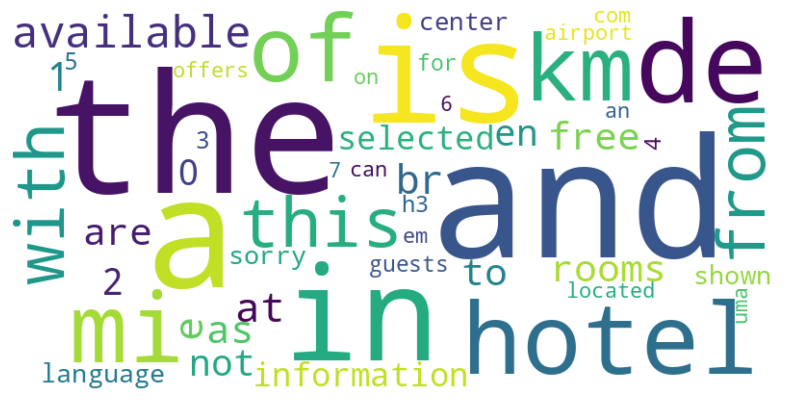

In [15]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

word_counts = t.word_counts

# Criar um dicionário de palavras para a nuvem
wordcloud_dict = {word: count for word, count in list(sorted_words.items())[:50]}

# Criar a nuvem de palavras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_dict)

# Plotar a nuvem de palavras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [ ]:
print('Found %s unique tokens.' % len(t.word_index))

Found 7553 unique tokens.


Tokenization: Padronizando os textos(aplicação de letra minuscula,retirada de caracteres especiais)
- Remoção de pontuação e caracteres especiais.
- Textos em sequências de palavras separadas por espaço em letras minúsculas.
- Divisão das sequencias em tokens.
- char_level=False : cada palavra será tratada como um token diferente de caractere.
- As listas de tokens são indexadas e vetorizadas.


In [ ]:
# Tokenization
t = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token=None, document_count=0)

def get_sequence_of_tokens(corpus):
    t.fit_on_texts(corpus)
    total_words = len(t.word_index) + 1
    
    input_sequences = []
    for line in corpus:
        token_list = t.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
            
    return input_sequences, total_words

In [ ]:
input_sequences, total_words = get_sequence_of_tokens(corpus)


As frases passam a ser representadas por números.

"Located(45) in Nice's city center, Best Western Hotel Lakmi Nice is located(45) on Avenue Jean Medecin" é representado pela sequencia abaixo:

In [ ]:
input_sequences[:15]

[[45, 5],
 [45, 5, 2698],
 [45, 5, 2698, 94],
 [45, 5, 2698, 94, 33],
 [45, 5, 2698, 94, 33, 279],
 [45, 5, 2698, 94, 33, 279, 343],
 [45, 5, 2698, 94, 33, 279, 343, 7],
 [45, 5, 2698, 94, 33, 279, 343, 7, 2699],
 [45, 5, 2698, 94, 33, 279, 343, 7, 2699, 1337],
 [45, 5, 2698, 94, 33, 279, 343, 7, 2699, 1337, 4],
 [45, 5, 2698, 94, 33, 279, 343, 7, 2699, 1337, 4, 45],
 [45, 5, 2698, 94, 33, 279, 343, 7, 2699, 1337, 4, 45, 43],
 [45, 5, 2698, 94, 33, 279, 343, 7, 2699, 1337, 4, 45, 43, 1338],
 [45, 5, 2698, 94, 33, 279, 343, 7, 2699, 1337, 4, 45, 43, 1338, 3870],
 [45, 5, 2698, 94, 33, 279, 343, 7, 2699, 1337, 4, 45, 43, 1338, 3870, 3871]]

In [ ]:
corpus[:1]

["Located in Nice's city center, Best Western Hotel Lakmi Nice is located on Avenue Jean Medecin, Nice's main shopping street which leads to Place Massena. It is next to Nice Etoile Shopping Center and is just 1969 feet from Nice- Ville Train Station. Each spacious air-conditioned guest room has a flat- screen TV and a private bathroom fitted with a hairdryer. Some of the soundproofed rooms feature wrought iron furniture and some rooms offer a balcony. WiFi access is available throughout the hotel. A buffet breakfast is served every morning in the breakfast room at the Best Western Hotel Lakmi Nice. Newspapers are available for guests and there is also a bar on site. The Promenade des Anglais is a 13-minute walk from the hotel and Vieux Nice, the historic district, is a 15-minute walk away. Six private parking spaces are available on site at an additional cost, which cannot be booked in advance. ((* Sorry, this information is not available in the selected language and is shown in EN)."

In [ ]:
total_words

7554

Deixando as sequences com o mesmo comprimento, transformando numeros inteiros em uma matriz 2D (num_samples,maxlen)

In [ ]:
# pad sequences 
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen = max_sequence_len, padding = 'pre'))
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = ku.to_categorical(label, num_classes = total_words)
    
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(input_sequences)

Criando o Modelo:
- Modelo LSTM com 100 unidades de memória
- Dropout com probalidade de 10.
- Problema de classificação de palavra com 7553 classes.
- Camada de saída Dense com ativação em softmax.
- Uso de otimização ADAM para velocidade

In [ ]:
def create_model(max_sequence_len, total_words):
    model = Sequential()
    
    # Add Input Embedding Layer
    model.add(Embedding(total_words, 10, input_length=max_sequence_len - 1))
    
    # Add Hidden Layer 1 - LSTM Layer
    model.add(LSTM(100))
    model.add(Dropout(0.1))
    
    # Add Output Layer
    model.add(Dense(total_words, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

model = create_model(max_sequence_len, total_words)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 727, 10)           75540     
                                                                 
 lstm (LSTM)                 (None, 100)               44400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 7554)              762954    
                                                                 
Total params: 882,894
Trainable params: 882,894
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(predictors, label, epochs=10, verbose=5)

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


In [ ]:
def generate_text(seed_text, next_words, model, max_seq_len):
    for _ in range(next_words):
        token_list = t.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_seq_len-1, padding='pre')
        
        #predicted = model.predict_classes(token_list, verbose=0)
        predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)
        output_word = ''
        
        for word,index in t.word_index.items():
            if index == predicted:
                output_word = word
                break
                
        seed_text = seed_text + " " + output_word
        
    return seed_text.title()

In [ ]:
print(generate_text("hilton seattle downtown", 100, model, max_sequence_len))


Hilton Seattle Downtown Hotel Is Located In The Heart Of The Historic Of The Hotel In The Heart Of The Heart Of The Heart Of The Hotel The Hotel Is Within Walking Distance Of The Hotel And The Beach Of The Hotel The Hotel Is Within Walking Distance Of The Hotel And The Hotel Is Just Minutes Away From The Hotel And The Hotel Is A Short Drive Away The Hotel Is A Short Drive Away And A Variety Of The Hotel The Hotel Offers A Variety Of The Hotel In The Hotel In The Hotel In The Heart Of The Heart Of


In [ ]:
print(generate_text("Holiday Inn Express - New York City, City-center hotel, walk to Madison Square Garden", 100, model, max_sequence_len))

Holiday Inn Express - New York City, City-Center Hotel, Walk To Madison Square Garden By Wyndham Wapakoneta Is A Short Drive From The Beach Of The Beach The Hotel Is Just A Short Drive From The Hotel And The Beach Of The City Of The Hotel The Hotel Is Just Close From The Historic Of The The Conditioned And The Hotel The Hotel Is Just Minutes From The Historic Of The Hotel The Hotel Is Within Walking Distance Of The Hotel The Hotel Is Just A Short Drive Away And A Variety Of The Hotel The Hotel Offers A Variety Of The Hotel In The Hotel In The Hotel In The Hotel In The


# Teste 2 - Apenas Hoteis Brasileiros (Descrição em português)

- Identificação do idioma das descrições, visando otimizar o modelo.
- Utilização da Descrição curta e aumanto das camadas de teste.

In [23]:
data = pd.read_json('/content/gdrive/My Drive/Colab Notebooks/inventory_hotel_BR_pt.json')
data = data[['short_description','description']]


In [ ]:
data['idioma'] = ''


for i in range(len(data['description'])):
    description = str(data['description'][i])
    if description.strip() and len(description) > 3:
        data.at[i, 'idioma'] = langdetect.detect(description)
    else:
        data.at[i, 'idioma'] = 'Desconhecido'

data

In [ ]:
name_counts = data['idioma'].value_counts()
name_counts_df = pd.DataFrame({'Nome': name_counts.index, 'Contagem': name_counts.values})
total = name_counts_df['Contagem'].sum()
name_counts_df['Percentual'] = (name_counts_df['Contagem'] / total * 100).round(1)
table = tabulate(name_counts_df, headers='keys', tablefmt='fancy_grid')
print(table)

╒════╤══════════════╤════════════╤══════════════╕
│    │ Nome         │   Contagem │   Percentual │
╞════╪══════════════╪════════════╪══════════════╡
│  0 │ en           │      88571 │         86.9 │
├────┼──────────────┼────────────┼──────────────┤
│  1 │ pt           │      12572 │         12.3 │
├────┼──────────────┼────────────┼──────────────┤
│  2 │ es           │        344 │          0.3 │
├────┼──────────────┼────────────┼──────────────┤
│  3 │ Desconhecido │        303 │          0.3 │
├────┼──────────────┼────────────┼──────────────┤
│  4 │ tr           │         41 │          0   │
├────┼──────────────┼────────────┼──────────────┤
│  5 │ ro           │         25 │          0   │
├────┼──────────────┼────────────┼──────────────┤
│  6 │ fr           │         12 │          0   │
├────┼──────────────┼────────────┼──────────────┤
│  7 │ de           │          3 │          0   │
├────┼──────────────┼────────────┼──────────────┤
│  8 │ ca           │          3 │          0   │


In [ ]:
hotelBR_df= data[data['idioma']=='pt']
hotelBR_df.reset_index(inplace = True)
hotelBR_df = hotelBR_df[0:300]

In [ ]:
hotelBR_df

,index,short_description,description,idioma
0,4,"Localizado no coração de São Paulo, o Grand Me...","Localizado no coração de São Paulo, o Grand Me...",pt
1,8,Com uma estadia Candiland Apartment em Semaran...,<h3>Localização Do Estabelecimento</h3>\nCom u...,pt
2,10,"Deleite-se com uma ida ao spa, que oferece mas...",<h3>Localização Do Estabelecimento</h3>\nEm La...,pt
3,21,Este agradável hotel encontra-se em Norco Area...,"Não perca as atividades de recreação, como uma...",pt
4,24,"Em Chetumal, Hotel Mexico ficará a 2 minuto(s)...",<h3>Localização Do Estabelecimento</h3>\nEm Ch...,pt
...,...,...,...,...
295,2190,Tradição e hospitalidade\n\nCom mais de 40 ano...,Tradição e hospitalidade\n\nCom mais de 40 ano...,pt
296,2192,Estilo e conforto completam as 172 acomodações...,Estilo e conforto completam as 172 acomodações...,pt
297,2195,Contemple fantásticas vistas a partir da açote...,Aprecie a vista em um terraço e um jardim e ap...,pt
298,2222,Algumas das comodidades e serviços em destaque...,"Aproveite a conveniência de comodidades, como ...",pt


In [ ]:
all_descriptionsBR = list(hotelBR_df['short_description'].values)

hotelBR_df.describe()

,index
count,384.000000
mean,506.278646
std,292.383762
min,2.000000
25%,232.750000
50%,514.000000
75%,768.750000
max,1001.000000


In [ ]:
hotelBR_df.columns

Index(['index', 'name', 'short_description', 'idioma'], dtype='object')

In [ ]:
#hotelBR_df[['name','price_currency','possible_integrators','description','short_description','small_description']]

In [ ]:
corpusBR = [x for x in all_descriptionsBR]
corpusBR[:1]


['Há várias opções de lazer e entretenimento ao seu dispor, incluindo uma piscina interior, uma banheira de hidromassagem e uma sala de fitness. As facilidades adicionais incluem Wi-fi grátis, armazenamento de esquis e uma loja de presentes/quiosque de']

In [ ]:
tBR = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token=None, document_count=0)
tBR.fit_on_texts(corpusBR)

In [ ]:
# A dictionary of words and their counts.
print(tBR.word_counts)

# A dictionary of words and how many documents each appeared in.
print(tBR.word_docs)

# An integer count of the total number of documents that were used to fit the Tokenizer (i.e. total number of documents)
print(tBR.document_count)

# A dictionary of words and their uniquely assigned integers.
print(tBR.word_index)

OrderedDict([('há', 11), ('várias', 181), ('opções', 45), ('de', 876), ('lazer', 102), ('e', 765), ('entretenimento', 98), ('ao', 182), ('seu', 143), ('dispor', 143), ('incluindo', 189), ('uma', 478), ('piscina', 153), ('interior', 67), ('banheira', 42), ('hidromassagem', 46), ('sala', 117), ('fitness', 101), ('as', 160), ('facilidades', 72), ('adicionais', 86), ('incluem', 87), ('wi', 278), ('fi', 276), ('grátis', 259), ('armazenamento', 7), ('esquis', 7), ('loja', 32), ('presentes', 32), ('quiosque', 29), ('localizado', 14), ('no', 103), ('coração', 2), ('são', 39), ('paulo', 2), ('o', 164), ('grand', 2), ('mercure', 1), ('sp', 2), ('vila', 2), ('olimpia', 1), ('ex', 2), ('caesar', 1), ('business', 1), ('está', 30), ('próximo', 4), ('a', 239), ('grandes', 1), ('centros', 1), ('financeiros', 1), ('importantes', 1), ('empresas', 1), ('por', 16), ('perto', 1), ('também', 49), ('excelentes', 1), ('bares', 3), ('restaurantes', 4), ('shoppings', 1), ('variados', 2), ('locais', 5), ('entret

In [ ]:
print('Found %s unique tokens.' % len(tBR.word_index))

Found 1113 unique tokens.


In [ ]:
# Tokenization
tBR = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token=None, document_count=0)

def get_sequence_of_tokensBR(corpusBR):
    tBR.fit_on_texts(corpusBR)
    total_wordsBR = len(tBR.word_index) + 1
    
    input_sequencesBR = []
    for line in corpusBR:
        token_list = tBR.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequencesBR.append(n_gram_sequence)
            
    return input_sequencesBR, total_wordsBR

In [ ]:
input_sequencesBR, total_wordsBR = get_sequence_of_tokensBR(corpusBR)


In [ ]:
input_sequencesBR[:10]

[[153, 12],
 [153, 12, 65],
 [153, 12, 65, 1],
 [153, 12, 65, 1, 28],
 [153, 12, 65, 1, 28, 2],
 [153, 12, 65, 1, 28, 2, 32],
 [153, 12, 65, 1, 28, 2, 32, 11],
 [153, 12, 65, 1, 28, 2, 32, 11, 17],
 [153, 12, 65, 1, 28, 2, 32, 11, 17, 18],
 [153, 12, 65, 1, 28, 2, 32, 11, 17, 18, 9]]

In [ ]:
total_wordsBR

1114

In [ ]:
# pad sequences 
def generate_padded_sequencesBR(input_sequencesBR):
    max_sequence_lenBR = max([len(x) for x in input_sequencesBR])
    input_sequencesBR = np.array(pad_sequences(input_sequencesBR, maxlen = max_sequence_lenBR, padding = 'pre'))
    predictorsBR, labelBR = input_sequencesBR[:,:-1],input_sequencesBR[:,-1]
    labelBR = ku.to_categorical(labelBR, num_classes = total_wordsBR)
    
    return predictorsBR, labelBR, max_sequence_lenBR

predictorsBR, labelBR, max_sequence_lenBR = generate_padded_sequencesBR(input_sequencesBR)

In [ ]:
def create_modelBR(max_sequence_lenBR, total_wordsBR):
    modelBR = Sequential()
    
    # Add Input Embedding Layer
    modelBR.add(Embedding(total_wordsBR, 10, input_length=max_sequence_lenBR - 1))
    
    # Add Hidden Layer 1 - LSTM Layer
    modelBR.add(LSTM(100))
    modelBR.add(Dropout(0.1))
    
    # Add Output Layer
    modelBR.add(Dense(total_wordsBR, activation='softmax'))

    modelBR.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return modelBR

modelBR = create_modelBR(max_sequence_lenBR, total_wordsBR)
modelBR.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 55, 10)            11140     
                                                                 
 lstm (LSTM)                 (None, 100)               44400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1114)              112514    
                                                                 
Total params: 168,054
Trainable params: 168,054
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelBR.fit(predictorsBR, labelBR, epochs=50, verbose=1)

Epoch 1/50
386/386 [==============================] - 21s 42ms/step - loss: 5.3071
Epoch 2/50
386/386 [==============================] - 10s 25ms/step - loss: 4.6266
Epoch 3/50
386/386 [==============================] - 11s 29ms/step - loss: 3.9561
Epoch 4/50
386/386 [==============================] - 15s 38ms/step - loss: 3.3992
Epoch 5/50
386/386 [==============================] - 21s 54ms/step - loss: 2.9787
Epoch 6/50
386/386 [==============================] - 21s 55ms/step - loss: 2.6547
Epoch 7/50
386/386 [==============================] - 21s 53ms/step - loss: 2.3988
Epoch 8/50
386/386 [==============================] - 21s 54ms/step - loss: 2.1856
Epoch 9/50
386/386 [==============================] - 21s 55ms/step - loss: 2.0177
Epoch 10/50
386/386 [==============================] - 21s 54ms/step - loss: 1.8658
Epoch 11/50
386/386 [==============================] - 21s 54ms/step - loss: 1.7378
Epoch 12/50
386/386 [==============================] - 22s 56ms/step - loss: 1.6259
E

In [ ]:
def generate_textBR(seed_textBR, next_wordsBR, modelBR, max_seq_lenBR):
    for _ in range(next_wordsBR):
        token_listBR = tBR.texts_to_sequences([seed_textBR])[0]
        token_listBR = pad_sequences([token_listBR], maxlen=max_seq_lenBR-1, padding='pre')
        
        #predicted = model.predict_classes(token_list, verbose=0)
        predicted = np.argmax(modelBR.predict(token_listBR, verbose=0), axis=-1)
        output_word = ''
        
        for word,index in tBR.word_index.items():
            if index == predicted:
                output_word = word
                break
                
        seed_textBR = seed_textBR + " " + output_word
        
    return seed_textBR.title()

In [ ]:
print(generate_textBR("Buzios Beach localizado em Buzios", 100, modelBR, max_sequence_lenBR))

Buzios Beach Localizado Em Buzios Atenas A Apenas 20 Metros Da Praia Não Temos Luxo Do Local Este Hotel Foi Totalmente Remodelado Em 36 Quartos À Internet Sem Fios Acessível O Alojamento O Hotel Oferece Ligação De Internet Por Wi Fi No Local Os Hóspedes Podem Contact Apreciarão A Receção Aberta 24 Horas Por Dia As Áreas Comuns São Adequadas Para Pessoas E N A Pontos De Artesanato Os Quartos E Os Aeroporto Os Quartos Os Hóspedes Podem Usufruir Da Ligação É Quartos Por Wi Fi Nas Áreas Para Bicicletas No Hotel Wi Fi Grátis Serviços De Negócio Todos Os Variados Locais De N Podem


In [ ]:
print(generate_textBR("Hotel localizado em Copacabana", 100, modelBR, max_sequence_lenBR))

Hotel Localizado Em Copacabana Serviço De Hospedagem Simples Com Conforto E Ótima Localização Não Temos Luxo E De Lazer Em Nossa Infraestrutura Somos Uma Opção De Hospedagem Ideal Para Quem Quer Durante Os Dias Conhecer Os Passeios De Alojamento Wi Fi Nas Áreas Comuns Os Hóspedes Podem Contactar A Receção A Qualquer Hora Do Dia O Imóvel E A Receção A Qualquer Hora A Interesse Do Jardim Do Jardim E A Propriedade Oferece Oferece Receção 24 Horas E Os Local Os Hóspedes Podem Contact E A 7 5 Km Da Km Da Artesanato Fica A Cerca De Barreirinhas A 2 2 Km Da Casa


In [ ]:
total_wordsBR

# Teste com descrições em Inglês

In [ ]:
hotelUS = pd.read_json(r'C:/Users/jgjoa/Desktop/FGV/inventory_hotel_BR_pt.json')
#hotelBR_df = hotelBR_df[hotelBR_df['country']=='Brasil']

hotelUS  = hotelUS[hotelUS['description']!='']
hotelUS = hotelUS[0:300]

In [ ]:
hotelUS['small_description']

0      Nice, France. ((* Sorry, this information is n...
1      Notting Hill - Paddington Station Area. ((* So...
2      Há várias opções de lazer e entretenimento ao ...
3      Fort Collins North. ((* Sorry, this informatio...
4      Localizado no coração de São Paulo, o Grand Me...
                             ...                        
295    Johnson City. ((* Sorry, this information is n...
296    Desfrute de fantásticas vistas a partir da aço...
297    Se procura lazer e entretenimento, poderá cont...
298    Arlington - Grand Prairie. ((* Sorry, this inf...
299    Property LocationWith a stay at Island View Ho...
Name: small_description, Length: 300, dtype: object

In [ ]:
langdetect.detect(str(hotelUS['description'][2]))

'en'

In [ ]:
hotelUS = hotelUS[['name','description']]

hotelUS['idioma'] = ''
hotelUS.reset_index(inplace= True)

for i in range(len(hotelUS['description'])):
    description = str(hotelUS['description'][i])
    if description.strip() and len(description) > 5:
        hotelUS.at[i, 'idioma'] = langdetect.detect(description)
    else:
        hotelUS.at[i, 'idioma'] = 'Desconhecido'

hotelUS

,index,name,description,idioma
0,0,Best Western Hôtel New York Nice,"Located in Nice's city center, Best Western Ho...",en
1,1,Comfort Inn Hyde Park,"In London's Bayswater district, the Comfort In...",en
2,2,Best Western Plus Dayton Hotel & Suites,Breakfast is offered daily and rooms feature f...,en
3,3,"The Elizabeth Hotel, Autograph Collection","The Elizabeth Hotel, Autograph Collection feat...",en
4,4,Grand Mercure Vila Olímpia,"Localizado no coração de São Paulo, o Grand Me...",pt
...,...,...,...,...
295,295,Traditions at the Glen Resort and Hotel,"Featuring an 18-hole golf course, this New Yor...",en
296,296,Restaurant Le Moschenross,"Located in the center of Thann, Hôtel Restaura...",en
297,297,AmericInn Lodge & Suites Mitchell,"Serving a daily continental breakfast, this Mi...",en
298,298,Courtyard Dallas Arlington/Entertainment District,This hotel is located less than 15 minutes’ wa...,en


In [ ]:
hotelUS= hotelUS[hotelUS['idioma']=='en']

In [ ]:
hotelUS.reset_index(inplace= True)
hotelUS

,level_0,index,name,description,idioma
0,0,0,Best Western Hôtel New York Nice,"Located in Nice's city center, Best Western Ho...",en
1,1,1,Comfort Inn Hyde Park,"In London's Bayswater district, the Comfort In...",en
2,2,2,Best Western Plus Dayton Hotel & Suites,Breakfast is offered daily and rooms feature f...,en
3,3,3,"The Elizabeth Hotel, Autograph Collection","The Elizabeth Hotel, Autograph Collection feat...",en
4,5,5,Bang Sarey Nordic Resort,"Located in Sattahip, 15 miles from Eastern Sta...",en
...,...,...,...,...,...
245,295,295,Traditions at the Glen Resort and Hotel,"Featuring an 18-hole golf course, this New Yor...",en
246,296,296,Restaurant Le Moschenross,"Located in the center of Thann, Hôtel Restaura...",en
247,297,297,AmericInn Lodge & Suites Mitchell,"Serving a daily continental breakfast, this Mi...",en
248,298,298,Courtyard Dallas Arlington/Entertainment District,This hotel is located less than 15 minutes’ wa...,en


In [ ]:
all_descriptionsUS = list(hotelUS['description'].values)

hotelUS.describe()

,level_0,index
count,250.000000,250.000000
mean,152.392000,152.392000
std,87.175804,87.175804
min,0.000000,0.000000
25%,76.500000,76.500000
50%,151.500000,151.500000
75%,229.500000,229.500000
max,299.000000,299.000000


In [ ]:
corpusUS = [x for x in all_descriptionsUS]
corpusUS[:1]

["Located in Nice's city center, Best Western Hotel Lakmi Nice is located on Avenue Jean Medecin, Nice's main shopping street which leads to Place Massena. It is next to Nice Etoile Shopping Center and is just 1969 feet from Nice- Ville Train Station. Each spacious air-conditioned guest room has a flat- screen TV and a private bathroom fitted with a hairdryer. Some of the soundproofed rooms feature wrought iron furniture and some rooms offer a balcony. WiFi access is available throughout the hotel. A buffet breakfast is served every morning in the breakfast room at the Best Western Hotel Lakmi Nice. Newspapers are available for guests and there is also a bar on site. The Promenade des Anglais is a 13-minute walk from the hotel and Vieux Nice, the historic district, is a 15-minute walk away. Six private parking spaces are available on site at an additional cost, which cannot be booked in advance. ((* Sorry, this information is not available in the selected language and is shown in EN)."

In [ ]:
tUS = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token=None, document_count=0)
tUS.fit_on_texts(corpusUS)

In [ ]:
# A dictionary of words and their counts.
print(tUS.word_counts)

# A dictionary of words and how many documents each appeared in.
print(tUS.word_docs)

# An integer count of the total number of documents that were used to fit the Tokenizer (i.e. total number of documents)
print(tUS.document_count)

# A dictionary of words and their uniquely assigned integers.
print(tUS.word_index)

OrderedDict([('located', 176), ('in', 1022), ("nice's", 2), ('city', 72), ('center', 207), ('best', 32), ('western', 25), ('hotel', 512), ('lakmi', 2), ('nice', 5), ('is', 1305), ('on', 179), ('avenue', 2), ('jean', 1), ('medecin', 1), ('main', 11), ('shopping', 45), ('street', 16), ('which', 38), ('leads', 1), ('to', 296), ('place', 22), ('massena', 1), ('it', 59), ('next', 6), ('etoile', 1), ('and', 1743), ('just', 82), ('1969', 2), ('feet', 46), ('from', 418), ('ville', 1), ('train', 19), ('station', 48), ('each', 79), ('spacious', 29), ('air', 84), ('conditioned', 46), ('guest', 71), ('room', 159), ('has', 84), ('a', 1277), ('flat', 91), ('screen', 94), ('tv', 134), ('private', 110), ('bathroom', 63), ('fitted', 17), ('with', 441), ('hairdryer', 32), ('some', 47), ('of', 486), ('the', 1781), ('soundproofed', 3), ('rooms', 292), ('feature', 40), ('wrought', 1), ('iron', 5), ('furniture', 4), ('offer', 41), ('balcony', 21), ('wifi', 65), ('access', 122), ('available', 412), ('through

In [ ]:
print('Found %s unique tokens.' % len(tUS.word_index))

Found 3868 unique tokens.


In [ ]:
# Tokenization
tUS = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n0123456789', lower=True, split=' ', char_level=False, oov_token=None, document_count=0)

def get_sequence_of_tokensUS(corpusUS):
    tUS.fit_on_texts(corpusUS)
    total_wordsUS = len(tUS.word_index) + 1
    
    input_sequencesUS = []
    for line in corpusUS:
        token_list = tUS.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequencesUS.append(n_gram_sequence)
            
    return input_sequencesUS, total_wordsUS

In [ ]:
input_sequencesUS, total_wordsUS = get_sequence_of_tokensUS(corpusUS)


In [ ]:
input_sequencesUS[:10]

[[29, 5],
 [29, 5, 1310],
 [29, 5, 1310, 86],
 [29, 5, 1310, 86, 24],
 [29, 5, 1310, 86, 24, 153],
 [29, 5, 1310, 86, 24, 153, 196],
 [29, 5, 1310, 86, 24, 153, 196, 6],
 [29, 5, 1310, 86, 24, 153, 196, 6, 1311],
 [29, 5, 1310, 86, 24, 153, 196, 6, 1311, 693],
 [29, 5, 1310, 86, 24, 153, 196, 6, 1311, 693, 3]]

In [ ]:
# pad sequences 
def generate_padded_sequencesUS(input_sequencesUS):
    max_sequence_lenUS = max([len(x) for x in input_sequencesUS])
    input_sequencesUS = np.array(pad_sequences(input_sequencesUS, maxlen = max_sequence_lenUS, padding = 'pre'))
    predictorsUS, labelUS = input_sequencesUS[:,:-1],input_sequencesUS[:,-1]
    labelUS = ku.to_categorical(labelUS, num_classes = total_wordsUS)
    
    return predictorsUS, labelUS, max_sequence_lenUS

predictorsUS, labelUS, max_sequence_lenUS = generate_padded_sequencesUS(input_sequencesUS)

In [ ]:
def create_modelUS(max_sequence_lenUS, total_wordsUS):
    modelUS = Sequential()
    
    # Add Input Embedding Layer
    modelUS.add(Embedding(total_wordsUS, 10, input_length=max_sequence_lenUS - 1))
    
    # Add Hidden Layer 1 - LSTM Layer
    modelUS.add(LSTM(100))
    modelUS.add(Dropout(0.1))
    
    # Add Output Layer
    modelUS.add(Dense(total_wordsUS, activation='softmax'))

    modelUS.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return modelUS

modelUS = create_modelUS(max_sequence_lenUS, total_wordsUS)
modelUS.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 720, 10)           37190     
                                                                 
 lstm_1 (LSTM)               (None, 100)               44400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 3719)              375619    
                                                                 
Total params: 457,209
Trainable params: 457,209
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelUS.fit(predictorsUS, labelUS, epochs=50, verbose=1)

Epoch 1/50
 988/1097 [==========================>...] - ETA: 1:50 - loss: 6.2534

In [ ]:
def generate_textBR(seed_textBR, next_wordsBR, modelBR, max_seq_lenBR):
    for _ in range(next_wordsBR):
        token_listBR = tBR.texts_to_sequences([seed_textBR])[0]
        token_listBR = pad_sequences([token_listBR], maxlen=max_seq_lenBR-1, padding='pre')
        
        #predicted = model.predict_classes(token_list, verbose=0)
        predicted = np.argmax(modelBR.predict(token_listBR, verbose=0), axis=-1)
        output_word = ''
        
        for word,index in tBR.word_index.items():
            if index == predicted:
                output_word = word
                break
                
        seed_textBR = seed_textBR + " " + output_word
        
    return seed_textBR.title()

In [ ]:
print(generate_textBR("Buzios Beach localizado em Buzios", 100, modelBR, max_sequence_lenBR))

# Description GPT2
https://huggingface.co/gpt2

https://www.kaggle.com/code/changyeop/how-to-fine-tune-gpt-2-for-beginners

In [ ]:
!pip install transformers


In [ ]:
!pip3 install torch torchvision torchaudio

In [ ]:
!pip install torch==1.10.0

ERROR: Could not install packages due to an OSError: [WinError 5] Acesso negado: 'C:\\Users\\jgjoa\\anaconda3\\Lib\\site-packages\\~vfuser\\_C.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



     -------------------------------------- 226.5/226.5 MB 2.9 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu117
    Uninstalling torch-2.0.1+cu117:
      Successfully uninstalled torch-2.0.1+cu117


In [ ]:
pip install --upgrade torch torchvision

     -------------------------------------- 172.4/172.4 MB 6.9 MB/s eta 0:00:00



  Attempting uninstall: torch
    Found existing installation: torch 1.10.0
    Uninstalling torch-1.10.0:
      Successfully uninstalled torch-1.10.0


In [ ]:
pip install transformers[torch]

     -------------------------------------- 219.1/219.1 kB 3.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: sympy in c:\users\jgjoa\anaconda3\lib\site-packages (from torch!=1.12.0,>=1.9->transformers[torch]) (1.10.1)



In [ ]:
torch.__version__

'2.0.1+cu117'

In [16]:
import torch
from torch.utils.data import TensorDataset
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

No GPU available, training on CPU; consider making n_epochs very small.


In [19]:
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import GPT2Tokenizer, GPT2LMHeadModel, TFGPT2Model,TFGPT2LMHeadModel
from transformers import Trainer, TrainingArguments
from transformers import TFTrainer, TFTrainingArguments
import tensorflow as tf

In [ ]:
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.7969, 0.3523, 0.4319],
        [0.8385, 0.5258, 0.4481],
        [0.0715, 0.5836, 0.8261],
        [0.7470, 0.7354, 0.0293],
        [0.5381, 0.2594, 0.3680]])


In [20]:
df_gpt= data[data['idioma']=='en']
df_gpt= df_gpt[data['description']!='']
df_gpt.reset_index(inplace = True)
df_gpt = df_gpt[0:300]

NameError: ignored

In [ ]:
df_gpt

,index,short_description,description,idioma
0,0,"Nice, France. ((* Sorry, this information is n...","Located in Nice's city center, Best Western Ho...",en
1,1,Notting Hill - Paddington Station Area. ((* So...,"In London's Bayswater district, the Comfort In...",en
2,2,Há várias opções de lazer e entretenimento ao ...,Breakfast is offered daily and rooms feature f...,en
3,3,"Fort Collins North. ((* Sorry, this informatio...","The Elizabeth Hotel, Autograph Collection feat...",en
4,5,"Alivie o stress com massagens, tratamentos cor...","Located in Sattahip, 15 miles from Eastern Sta...",en
...,...,...,...,...
295,352,"Downtown - Centro Historico. ((* Sorry, this i...","In the heart of Mexico City, just 10 minutes’ ...",en
296,353,"Oil City. ((* Sorry, this information is not a...",This lovely hotel is located in Oil City. Ther...,en
297,354,"Blue Ash. ((* Sorry, this information is not a...",Within 2 miles from Cincinnati Blue Ash Airpor...,en
298,355,"Richmond Hill. ((* Sorry, this information is ...",The Holiday Inn Express Savannah South is conv...,en


In [ ]:
def load_dataset(dataframe, tokenizer, block_size=128):
    texts = list(dataframe["description"])

    tokenizer.pad_token = tokenizer.eos_token
    encodings = tokenizer.batch_encode_plus(
        texts,
        max_length=block_size,
        truncation=True,
        padding="max_length",
    )

    input_ids = encodings["input_ids"]
    attention_mask = encodings["attention_mask"]

    input_ids = torch.tensor(input_ids)
    attention_mask = torch.tensor(attention_mask)

    dataset = TensorDataset(input_ids, attention_mask)
    return dataset

def load_data_collator(tokenizer, mlm=False):
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=mlm,
    )
    return data_collator

def load_data_collator(tokenizer, mlm = False):
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer, 
        mlm=mlm,
    )
    return data_collator


def train(train_dataframe, model_name,
          output_dir,
          overwrite_output_dir,
          per_device_train_batch_size,
          num_train_epochs,
          save_steps):
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    train_dataset = load_dataset(train_dataframe, tokenizer)
    #train_dataset = torch.tensor(train_dataset)
    data_collator = load_data_collator(tokenizer)

    tokenizer.save_pretrained(output_dir)

    model = GPT2LMHeadModel.from_pretrained(model_name)

    model.save_pretrained(output_dir)

    training_args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=overwrite_output_dir,
        per_device_train_batch_size=per_device_train_batch_size,
        num_train_epochs=num_train_epochs,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        train_dataset=train_dataset,
    )

    trainer.train()
    trainer.save_model()

In [ ]:
# you need to set parameters 
train_dataframe = df_gpt
model_name = 'gpt2'
output_dir = '/content/drive/MyDrive/result'
overwrite_output_dir = False
per_device_train_batch_size = 8
num_train_epochs = 5.0
save_steps = 500

In [ ]:
region_offset = torch.tensor(region_offset).int()

NameError: name 'region_offset' is not defined

In [ ]:
pip install --upgrade transformers


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: transformers in c:\users\jgjoa\anaconda3\lib\site-packages (4.29.2)


In [ ]:
!pip uninstall -y transformers accelerate
!pip install transformers accelerate

Found existing installation: transformers 4.29.2
Uninstalling transformers-4.29.2:
  Successfully uninstalled transformers-4.29.2
Found existing installation: accelerate 0.19.0
Uninstalling accelerate-0.19.0:
  Successfully uninstalled accelerate-0.19.0
  Using cached transformers-4.29.2-py3-none-any.whl (7.1 MB)
  Using cached accelerate-0.19.0-py3-none-any.whl (219 kB)


In [ ]:
pip install git+https://github.com/huggingface/accelerate


  Cloning https://github.com/huggingface/accelerate to c:\users\jgjoa\appdata\local\temp\pip-req-build-g2c23xo0
  Resolved https://github.com/huggingface/accelerate to commit e0ffea5bc3929dc9fae9da582f3b0f94fb7c4900
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate 'C:\Users\jgjoa\AppData\Local\Temp\pip-req-build-g2c23xo0'



  Created wheel for accelerate: filename=accelerate-0.20.0.dev0-py3-none-any.whl size=227218 sha256=3c3ffba36fae6bbce618b399146f4022cad0c73d34781cfacaea022e7e7a62a8
  Stored in directory: C:\Users\jgjoa\AppData\Local\Temp\pip-ephem-wheel-cache-dn2uawa5\wheels\f0\e3\1c\5f57b1bee1a190bc85fa69b9ec3d3aaab6a120724e5ca00a60
Successfully built accelerate
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.19.0
    Uninstalling accelerate-0.19.0:
      Successfully uninstalled accelerate-0.19.0


In [ ]:
!pip uninstall -y transformers
!pip install transformers==4.28.0


Found existing installation: transformers 4.29.2
Uninstalling transformers-4.29.2:
  Successfully uninstalled transformers-4.29.2
     ---------------------------------------- 7.0/7.0 MB 6.3 MB/s eta 0:00:00


In [ ]:
# It takes about 30 minutes to train in colab.
train(
    train_dataframe=train_dataframe,
    model_name=model_name,
    output_dir=output_dir,
    overwrite_output_dir=overwrite_output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    num_train_epochs=num_train_epochs,
    save_steps=save_steps
)

TypeError: only integer tensors of a single element can be converted to an index

In [ ]:
import nltk

import string
import unidecode
import random
import torch

In [ ]:
df_rnn= data[data['idioma']=='en']
df_rnn = df_rnn[0:1000]

In [ ]:

text = list(df_rnn['description'])
def joinStrings(text):
    return ' '.join(string for string in text)
text = joinStrings(text)
# text = [item for sublist in author[:5].values for item in sublist]
len(text.split())

143090

In [ ]:
stop = set(nltk.corpus.stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = nltk.stem.wordnet.WordNetLemmatizer()
def clean(doc):
        stop_free = " ".join([i for i in doc.split() if i not in stop])
        punc_free = "".join(ch for ch in stop_free if ch not in exclude)
        normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
        return normalized
test_sentence = clean(text).lower().split()

In [ ]:
trigrams = [([test_sentence[i], test_sentence[i + 1]], test_sentence[i + 2])
            for i in range(len(test_sentence) - 2)]
chunk_len=len(trigrams)
print(trigrams[:3])

[(['located', 'nices'], 'city'), (['nices', 'city'], 'center'), (['city', 'center'], 'best')]


In [ ]:
vocab = set(test_sentence)
voc_len=len(vocab)
word_to_ix = {word: i for i, word in enumerate(vocab)}

In [ ]:
inp=[]
tar=[]
for context, target in trigrams:
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
        inp.append(context_idxs)
        targ = torch.tensor([word_to_ix[target]], dtype=torch.long)
        tar.append(targ)

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size*2, hidden_size, n_layers,batch_first=True,
                          bidirectional=False)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [ ]:
def train(inp, target):
    hidden = decoder.init_hidden().cuda()
    decoder.zero_grad()
    loss = 0
    
    for c in range(chunk_len):
        output, hidden = decoder(inp[c].cuda(), hidden)
        loss += criterion(output, target[c].cuda())

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len



In [ ]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
!conda install pytorch torchvision cudatoolkit=10.1 -c pytorch



In [ ]:
print(torch.cuda.is_available)


<function is_available at 0x0000022DA453C310>


In [ ]:
torch.cuda.is_available()

False

In [ ]:
n_epochs = 100
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.015

decoder = RNN(voc_len, hidden_size, voc_len, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0
if(train_on_gpu):
    decoder.cuda()
for epoch in range(1, n_epochs + 1):
    loss = train(inp,tar)       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 50, loss))
#         print(evaluate('ge', 200), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0


AssertionError: Torch not compiled with CUDA enabled

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [ ]:
def evaluate(prime_str='this process', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden().cuda()

    for p in range(predict_len):
        
        prime_input = torch.tensor([word_to_ix[w] for w in prime_str.split()], dtype=torch.long).cuda()
        inp = prime_input[-2:] #last two words as input
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted word to string and use as next input
        predicted_word = list(word_to_ix.keys())[list(word_to_ix.values()).index(top_i)]
        prime_str += " " + predicted_word
#         inp = torch.tensor(word_to_ix[predicted_word], dtype=torch.long)

    return prime_str